# Predicting Customer Churn

## An introduction to machine learning classifiers in scikit-learn

This lab is adapted from Slater Stich's blogpost on Visualizng Machine Learning Thresholds:     http://blog.insightdatalabs.com/visualizing-classifier-thresholds/

In order to learn how to use machine learning classifiers in scikit-learn, let's look at the [famous telecom churn data set](https://bigml.com/user/francisco/gallery/dataset/5163ad540c0b5e5b22000383).     

This data set consists of information about phone plan subscribers; the goal is to predict which users will churn before the next billing period.

In [25]:
import pandas as pd
import numpy as np
%pylab inline

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


In [26]:
# Retrieve Data Set
df = pd.read_csv('http://www.dataminingconsultant.com/data/churn.txt')

In [27]:
# Let's check it out
df.head(5)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [28]:
df.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [29]:
# The data is a bit messy so we'll need to do some cleaning/prepreocessing. Let's make everything 
# lower case, replace the spaces with underscores, and remove the question marks and apostrophes.

df.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "") for c in df.columns]

In [30]:
# Now we can use label encoding to transform the text abbreviations in the 'state' column into 
# integer values.
#
# You can read more about label encoding here:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

state_encoder = LabelEncoder()
df.state = state_encoder.fit_transform(df.state)

In [31]:
# We don't need the 'phone' column (why not?), so let's drop it.

del df['phone']

In [32]:
# Three of the columns we want to use are binaries, but stored as text values like "Yes/No" or "True/False"
# These columns are: International Plan, Voicemail Plan, and Churn.
# We should convert (or 'map') those into numeric binaries so they'll be ready for scikit-learn.

binary_columns = ['intl_plan', 'vmail_plan', 'churn']
for col in binary_columns:
    df[col] = df[col].map({
            'no': 0
        ,   'False.': 0
        ,   'yes': 1
        ,   'True.': 1
    })

In [33]:
# Let's check out what things look like now

df.head(10)

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
5,1,118,510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0
6,19,121,510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0
7,24,147,415,1,0,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,0
8,18,117,408,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,0
9,49,141,415,1,1,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0


We want our machine learning algorithm to look for patterns and break our dataset into pieces,
so we need to pick a classifier. Let's begin with a random forest, which is a 'meta estimator'. 
It will fit a number of decision trees (we'll have to tell it how many) on various sub-samples 
of the dataset. Then it will use averaging to improve the predictive accuracy and control over-fitting.

Read more about Random Forests here:    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [38]:
# We'll select 50 trees and opt for 'out-of-bag' samples to estimate the generalization error.
clf = RandomForestClassifier(n_estimators=50, oob_score=True) 

In [39]:
# Next we want to divide our dataframe columns into signals and labels. The signals 
# are the information our machine learning algorith will use to make predictions.
# The labels are the "right answers". In this case, that will be the boolean 'churn', 
# meaning whether or not the customers left their phone plan.

signals = df[[c for c in df.columns if c != 'churn']]
labels = df['churn']

How many sub-samples should we specify?     

The training samples are constructed by splitting our original dataset into more than one part. But what if certain chunks of our data have more variance than others? We want to ensure that our model is accurate regardless of the particular way the data are divided up.    

This is called __cross-validation__.

More on cross-validation tools inside Scikit-learn here:    
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html

In [40]:
# Let's divide the data into 12 parts. Because that's Ben's favorite number.
test_size_percent = 0.083

In [41]:
# Next split up the data with the 'train test split' method in the Cross Validation module
train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)

# ...and then run the 'fit' method to build a forest of trees
clf.fit(train_signals, train_labels)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=50, n_jobs=1, oob_score=True,
            random_state=None, verbose=0)

How did we do? Let's use some visual diagnostic tools to find out:

In [45]:
# We can use the Random Forest 'predict probabilities' method on our test signals:
predictions = clf.predict_proba(test_signals)[:,1]

In [47]:
# And we can create a precision recall curve to evaluate the performance of our 
# model as a function of the threshold for switching carriers.
precision, recall, thresholds = precision_recall_curve(test_labels, predictions)
thresholds = np.append(thresholds, 1)

In [59]:
# For each threshold between 0 and 1 (e.g. from 0% to 100%), the queue rate gives us
# size of the treatment (intervention) group at that threshold.

queue_rate = []
for threshold in thresholds:
    queue_rate.append((predictions >= threshold).mean())

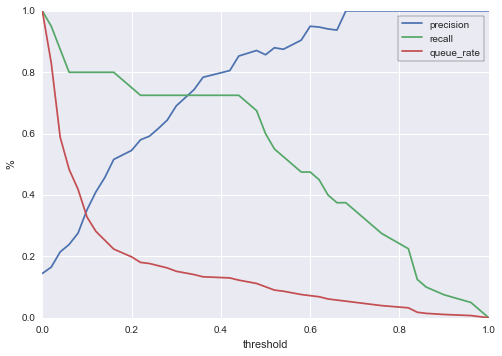

In [62]:
# Now we'll graph all three curves together
# Let's import a visualization library called Seaborn first to help us out

import seaborn as sns
sns.set_style('darkgrid')

plt.plot(thresholds, precision, color=sns.color_palette()[0])
plt.plot(thresholds, recall, color=sns.color_palette()[1])
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')

The precision value at that threshold tells us which percentage will actually
churn if they don't receive treatment.

The recall value at that threshold tells us what percentage of subscribers we
will retain thanks to our intervention.

The chart we produced above only shows the performance of a single train/test split. While we'd hope that this sample is indicative of likely model performance, it's better to visualize many train/test splits to get an idea of the range of possible performance outcomes. One of the simplest ways to do this is to perform many random train/test splits, and plot the curves for each. Here's what that looks like for 25 random splits on the telecom churn model:

In [65]:
clf = RandomForestClassifier(n_estimators=50, oob_score=True)

n_trials = 25
test_size_percent = 0.083

signals = df[[c for c in df.columns if c != 'churn']]
labels = df['churn']

plot_data = []

for trial in range(n_trials):
    train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]
    
    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)
    thresholds = np.append(thresholds, 1)
    
    queue_rate = []
    for threshold in thresholds:
        queue_rate.append((predictions >= threshold).mean())
            
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })    

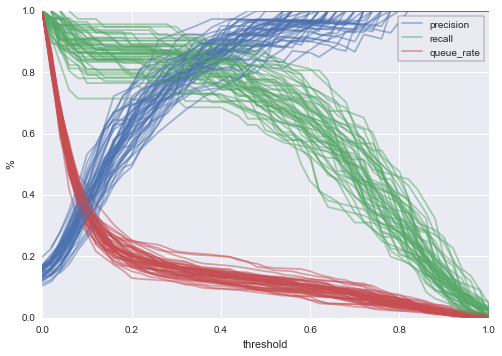

In [64]:
for p in plot_data:
    plt.plot(p['thresholds'], p['precision'], color=sns.color_palette()[0], alpha=0.5)
    plt.plot(p['thresholds'], p['recall'], color=sns.color_palette()[1], alpha=0.5)
    plt.plot(p['thresholds'], p['queue_rate'], color=sns.color_palette()[2], alpha=0.5)
    
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')

As expected, there's some variation and more uncertainty. How much? We can plot it like this:

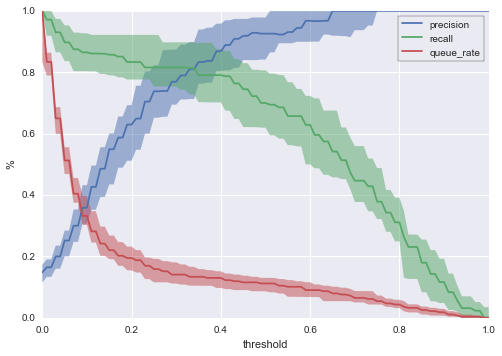

In [66]:
import bisect  
from scipy.stats import mstats

uniform_thresholds = np.linspace(0, 1, 101)

uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []

for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

quantiles = [0.1, 0.5, 0.9]  
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)  
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)  
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)  
plt.plot(uniform_thresholds, median_recall)  
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])  
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])  
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

What if we had picked a different classifier? 

http://scikit-learn.org/stable/auto_examples/plot_classifier_comparison.html